## A recommender system based on listing description text data

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

pd.set_option('display.max_columns', 100)

RANDOM_STATE= 42

In [2]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### Prepare data

In [5]:
# load dataset
df_raw = pd.read_pickle('../data/data_cleaned/cleaned_listing_and_review_with_polarity.zip')
print(df_raw.shape)

# fill non comments with empty
df = df_raw.copy()
df['comments'].fillna(' ', inplace=True)

# add content col
content_cols = ['listing_name', 'description', 
                'host_name', 'host_location', 'host_about',
                'host_response_time', 'host_neighbourhood',
                'host_verifications', 'neighbourhood_cleansed',
                'neighbourhood_group_cleansed','neighborhood_overview',
                'property_type', 'room_type','amenities',
               ]
# combine all text together
df['content'] = df.loc[:,content_cols].apply(lambda x: ' '.join(x), axis=1)
print(df.shape)

(4933, 73)
(4933, 74)


### Preprocess data

In [6]:
# prepare stopword set
added_stopwords = ["can't",'t', 'us', 'say','would', 'also','within','stay', 'since']
nltk_STOPWORDS = set(stopwords.words("english"))
nltk_STOPWORDS.update(added_stopwords)

def preprocess_text(text, stopwords = nltk_STOPWORDS, stem=False, lemma=False):
    
    # clean the text
    text = text.lower()
    # remove html and all other sybols 
    text = re.sub("(<.*?>)|([^0-9A-Za-z \t])","",text)
    text = re.sub("(br)", '', text)
    
    # tokenize the text
    text = word_tokenize(text)     
    # remove stopwords and non alpha words
    text = [word for word in text if word not in stopwords]
    
    # get the root of word
    if stem == True:   
        stemmer = PorterStemmer()
        text = [stemmer.stem(word) for word in text]   
    
    # normalize the word  
    if lemma == True:
        lemmatizer = WordNetLemmatizer()
        text = [lemmatizer.lemmatize(word) for word in text]
        
    # list to string
    text = ' '.join(text)  
    
    return text

In [7]:
%%time
# get cleaned content
df['cleaned_content'] = df['content'] \
                                    .apply(lambda x: preprocess_text(x,stopwords = nltk_STOPWORDS,stem=False, lemma=True))

print(df.shape)

(4933, 75)
CPU times: user 8.98 s, sys: 57.2 ms, total: 9.03 s
Wall time: 9.03 s


In [8]:
# save the dataset containing content and the cleaned_content cols to a file 
# which will be used for text-based recommender in streamlit app.

df.to_pickle('../data/data_cleaned/cleaned_listing_and_review_with_polarity_and_text_content.zip')

# # check and directly load the saved dataset
# df = pd.read_pickle('../data/data_cleaned/cleaned_listing_and_review_with_polarity_and_text_content.zip')
# print(df.shape)

In [9]:
# select final columns for recommender to show
listing_cols = ['listing_id','listing_url','review_scores_rating', 'polarity','comments'] 
df_rec = df.loc[:,[*listing_cols, *content_cols,'content','cleaned_content']]
print(df_rec.shape)
df_rec.head(2)

(4933, 21)


,listing_id,listing_url,review_scores_rating,polarity,comments,listing_name,description,host_name,host_location,host_about,host_response_time,host_neighbourhood,host_verifications,neighbourhood_cleansed,neighbourhood_group_cleansed,neighborhood_overview,property_type,room_type,amenities,content,cleaned_content
0,49113826,https://www.airbnb.com/rooms/49113826,4.83,0.817365,Unexpectedly the place was like new home since...,Private Seattle Getaway Home Near Lake Washing...,A Seattle vacation destination for those from ...,Xiao,"Seattle, WA",,within an hour,Oakland,"['email', 'phone']",Rainier View,Rainier Valley,SeaTac International Airport: 14 min drive<br ...,Entire home,Entire home/apt,"[""Hot water"", ""Dining table"", ""Toaster"", ""Refr...",Private Seattle Getaway Home Near Lake Washing...,private seattle getaway home near lake washing...
1,7455832,https://www.airbnb.com/rooms/7455832,4.89,0.913648,The house is so comfortable and clean. It has ...,Classic remodeled in Georgetown,Enjoy your Seattle stay in the vibrant & artis...,Ryan,"Seattle, WA",,within an hour,Greater Duwamish,"['email', 'phone', 'work_email']",Georgetown,Other neighborhoods,Georgetown is a cool neighborhood about three ...,Entire home,Entire home/apt,"[""Hot water"", ""Crib - available upon request"",...",Classic remodeled in Georgetown Enjoy your Sea...,classic remodeled georgetown enjoy seattle via...


In [10]:
# # use a small sample data to run
# df_rec = df_rec.sample(200, random_state = RANDOM_STATE).reset_index(drop=True)
# df_rec.head(2)

### Vectorize data

In [11]:
%%time
# vectorize data
def vectorize_data(corpus):
    # TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(
                                    ngram_range = (1,2),
                                        min_df=2,
                                        max_df=0.9,
                                    stop_words='english').fit(corpus)
    # update: use todense() and np.asarray to avoid error in streamlit app
    tfidf_matrix = tfidf_vectorizer.transform(corpus).todense()
    tfidf_matrix = np.asarray(tfidf_matrix)
    
    return tfidf_vectorizer, tfidf_matrix       

# get corpus
corpus = df_rec['content'].values
tfidf_vectorizer, tfidf_matrix = vectorize_data(corpus)
print(tfidf_matrix.shape)

(4933, 89226)
CPU times: user 3.8 s, sys: 965 ms, total: 4.77 s
Wall time: 4.77 s


In [12]:
# # save tfidf vectoirizer and matrix to files

# with open('data/cleaned_v2/tfidf_vectorizer.pk','wb') as file:
#     pickle.dump(tfidf_vectorizer,file)

# with open('data/cleaned_v2/tfidf_matrix.pk','wb') as file:
#     pickle.dump(tfidf_matrix,file)


# ## issue: tfidf_matrix can not be loaded.
# ## the size of pickled tfidf_matrix is about 3G,which exceeds the limitation of deepnote

# # check and load vectorizer and tfidf_matrix
# tfidf_vectorizer = pickle.load(open("data/data_cleaned/tfidf_vectorizer.pk", "rb"))
# tfidf_matrix = pickle.load(open("data/data_cleaned/tfidf_matrix.pk", "rb")) 
# print(tfidf_matrix.shape)

### Build text based recommender system

In [13]:
%%time
def get_similarity(input_query, tfidf_matrix):
    # preprocess and vectorize the input query
    tokens = preprocess_text(input_query,stopwords = nltk_STOPWORDS, stem=False, lemma=True).split()
    query_vector = tfidf_vectorizer.transform(tokens)
    
    # get similarity
    # update: speed the similarity calculation 
    tfidf_matrix_sparse = sparse.csr_matrix(tfidf_matrix)
    similarity = cosine_similarity(query_vector, tfidf_matrix_sparse)

    return similarity

# define an input query example
input_query = "I want a private room close to uw campus with parking and coffee shop"
similarity = get_similarity(input_query, tfidf_matrix)
print(similarity.shape)

(9, 4933)
CPU times: user 2 s, sys: 99.8 ms, total: 2.1 s
Wall time: 2.1 s


In [14]:
def get_recommendations(df, input_query, tfidf_matrix, n=5):
    
    def extract_best_indices(similarity, top_n, mask=None):
        """
        Use sum of the cosine distance over all tokens ans return best mathes.
        m (np.array): cos matrix of shape (nb_in_tokens, nb_dict_tokens)
        topk (int): number of indices to return (from high to lowest in order)
        """
        # return the sum on all tokens of consine for the input query
        if len(similarity.shape) > 1:
            cos_sim = np.mean(similarity, axis=0) 
        else: 
            cos_sim = similarity
        index = np.argsort(cos_sim)[::-1]

        mask = np.ones(len(cos_sim))
        mask = np.logical_or(cos_sim[index] != 0, mask) #eliminate 0 cosine distance
        best_index = index[mask][:top_n]  
        return best_index

    # best cosine distance for each token independantly
    best_index = extract_best_indices(similarity, top_n=n)
    
    # return the top n similar listing ids and raw comments
    result_df = df.loc[best_index, ['listing_id', 'listing_url', 'listing_name', 'description',
                                    'room_type','property_type',  
                                 'neighborhood_overview', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
                                 'host_about', 'amenities', 'comments', 'review_scores_rating']]     
    
    result_df.reset_index(drop=True, inplace=True)
    return result_df

#### Try the recommender system

In [15]:
#input_query = "I want a private room close to uw campus with parking and coffee shop"
input_query = "coffee private"
recomended_listings = get_recommendations(df_rec, input_query, tfidf_matrix, n=3)
recomended_listings

,listing_id,listing_url,listing_name,description,room_type,property_type,neighborhood_overview,neighbourhood_cleansed,neighbourhood_group_cleansed,host_about,amenities,comments,review_scores_rating
0,37640654,https://www.airbnb.com/rooms/37640654,Montlake Apt 3 blocks from UW Light Rail & Hosp.,Recently remodeled apartment in a 1926 Tudor i...,Entire home/apt,Entire rental unit,"Great coffee shop, small market and Italian re...",Montlake,Capitol Hill,My husband and I love to travel and host. We l...,"[""Hot water"", ""Shared patio or balcony"", ""Refr...",We had a wonderful experience in the sunny bas...,4.98
1,54166095,https://www.airbnb.com/rooms/54166095,Comfy Big Room by UW with Free Parking & Fast ...,Welcome to your big bedroom when visiting Seat...,Private room,Private room in bed and breakfast,,Wallingford,Other neighborhoods,I am a working mother has raised up 2 children...,"[""Hot water"", ""Refrigerator"", ""Hot water kettl...",This is a wonderful space. Ellen accommodated ...,4.64
2,3852185,https://www.airbnb.com/rooms/3852185,Room for rotating med students!,Our house is walking distance to University of...,Private room,Private room in home,This is a quiet neighborhood of single family ...,Montlake,Capitol Hill,,"[""Hot water"", ""Refrigerator"", ""Washer"", ""Kitch...",Lisa is an excellent host! She is always very ...,5.00


#### generate wordcloud for a recommended listing

In [16]:
def make_wordcloud(df, col, listing_id, stop_words, mask=None):
    
    if listing_id in df['listing_id'].values:
        text = df[df['listing_id'] == listing_id][col].values[0]
        wordcloud = WordCloud(width = 1000, 
                              height = 1000, 
                              stopwords=stop_words, 
                              scale=10, 
                              colormap = 'PuRd', 
                              background_color ='white',
#                               mask = None,
                              max_words=100,
                             ).generate(text)

        plt.figure(figsize=(8,8))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    else:
        print('Oops, this listing currently has no description.') 

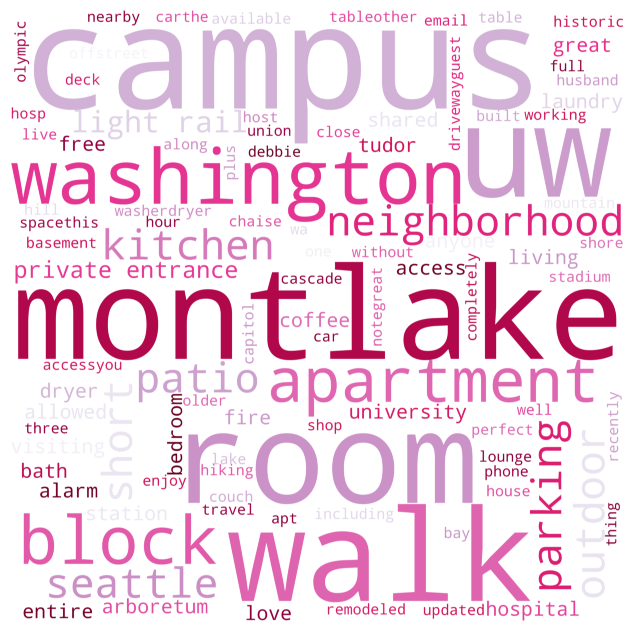

In [17]:
# generate wordcloud for a recommended listing (has comments)
top_1_recommended_listing = recomended_listings['listing_id'].values[0]
wordcloud_STOPWORDS = STOPWORDS
make_wordcloud(df_rec,'cleaned_content', top_1_recommended_listing, wordcloud_STOPWORDS, mask=None)

We can see words like uw, campus, university, private entrance, parking, coffee are in the first recommened listings.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2a50dc6-ff6a-45ff-9dbe-d7a35bd1e393' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>